#Image Classification Using Transfer Learning
Transfer learning and Fine-tuning

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import files
import gdown


In [4]:
gdown.download_folder('https://drive.google.com/drive/folders/1hU-x8M6PJNDFQIy4OiWW4GzCX9vt10UO', quiet=False)


Retrieving folder contents


Retrieving folder 1gAecpHIZOzeLqqbfbSTgbVSp-EZ3-15_ models
Processing file 1-5A3GSFUSM3l9b1lrg2emhiQESr5wi3Q model_VGG16.h5
Processing file 1vOQ5umopx0lN_IEEUeO-Mg2qgi33Xt38 model_VGG16.keras
Retrieving folder 1b0bEclIOkgNl1zi2fbPAceSA9nY4pc1_ photos
Processing file 1tgOmgKCnhIFpPY4UY75FW7vCKlv3cP_D frog.jpg
Processing file 1rhP54z6gJpD7GyjJ1we5eVW5UNNaGFJv horse.jpg
Processing file 1bgkCO35mpbjRi9lybAetuB63oGdyYOci Image_Classification_TL&FT.ipynb
Processing file 1nAKBvIO-N6L-agRRHAOnAvqLC5xZaM1l Image_Classification_VGG16.ipynb
Processing file 1RlFBJ975uDNdf8i88lDTI1rZOFKrqITU project_report.docx


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1-5A3GSFUSM3l9b1lrg2emhiQESr5wi3Q
From (redirected): https://drive.google.com/uc?id=1-5A3GSFUSM3l9b1lrg2emhiQESr5wi3Q&confirm=t&uuid=e0b0546a-7cc2-40c2-9038-d0e21f255570
To: /content/Image classification/models/model_VGG16.h5
100%|██████████| 179M/179M [00:01<00:00, 127MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1vOQ5umopx0lN_IEEUeO-Mg2qgi33Xt38
From (redirected): https://drive.google.com/uc?id=1vOQ5umopx0lN_IEEUeO-Mg2qgi33Xt38&confirm=t&uuid=d89cae91-ef5c-4007-89bc-8aa8c469ef73
To: /content/Image classification/models/model_VGG16.keras
100%|██████████| 179M/179M [00:01<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tgOmgKCnhIFpPY4UY75FW7vCKlv3cP_D
To: /content/Image classification/photos/frog.jpg
100%|██████████| 63.7k/63.7k [00:00<00:00, 52.4MB/s]
Downloading...
From: http

['/content/Image classification/models/model_VGG16.h5',
 '/content/Image classification/models/model_VGG16.keras',
 '/content/Image classification/photos/frog.jpg',
 '/content/Image classification/photos/horse.jpg',
 '/content/Image classification/Image_Classification_TL&FT.ipynb',
 '/content/Image classification/Image_Classification_VGG16.ipynb',
 '/content/Image classification/project_report.docx']

##1. Choose a Dataset

We'll use the CIFAR-10 dataset, which is available directly in Keras.

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


###Explanation:

* cifar10.load_data() - loads the dataset, splitting it into training and testing sets.

* x_train and x_test contain image data, while y_train and y_test contain labels.

* Normalizing the pixel values helps in speeding up the training process and improves model performance.

##2. Choose a Pre-trained Model
We'll use ResNet50 and VGG16 for transfer learning.

In [ ]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(10, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###Explanation:

* ResNet50 is loaded with pre-trained ImageNet weights, excluding the top layer (include_top=False) to add custom layers.

* Layers of the base model are set to non-trainable to keep the pre-trained weights.

* Flatten layer converts 3D feature maps to 1D feature vectors.

* Dense layers are added to adapt the model to the CIFAR-10 classification task with 10 classes.

* The model is compiled with the Adam optimizer and sparse categorical crossentropy loss, suitable for integer labels.

##3. Data Preprocessing and Augmentation
We'll use Keras' ImageDataGenerator for data augmentation.

In [ ]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the generator on the training data
datagen.fit(x_train)


###Explanation:

* ImageDataGenerator applies random transformations (e.g., rotations, shifts, flips) to the training data, which helps prevent overfitting.

##4. Train the Model

In [ ]:
# Train the model with augmented data
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(x_test, y_test))



Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.1166 - loss: 2.3194 - val_accuracy: 0.1718 - val_loss: 2.1741
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.1369 - loss: 2.2341 - val_accuracy: 0.1652 - val_loss: 2.1488
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.1440 - loss: 2.2234 - val_accuracy: 0.1810 - val_loss: 2.1515
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - accuracy: 0.1458 - loss: 2.2157 - val_accuracy: 0.1347 - val_loss: 2.2365
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.1496 - loss: 2.2132 - val_accuracy: 0.1839 - val_loss: 2.1301
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.1535 - loss: 2.2093 - val_accuracy: 0.1793 - val_loss: 2.1409
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.1550 - loss: 2.2102 - val_accuracy: 0.1937 - val_loss: 2.1266
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.1590 - loss: 2.20

###Explanation:

* model.fit - trains the model using augmented data.

* datagen.flow - generates batches of augmented images and labels.

##5. Evaluate the Model

In [ ]:
# Evaluate model performance on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


313/313 - 2s - 7ms/step - accuracy: 0.1600 - loss: 2.1655
Test accuracy: 0.1599999964237213


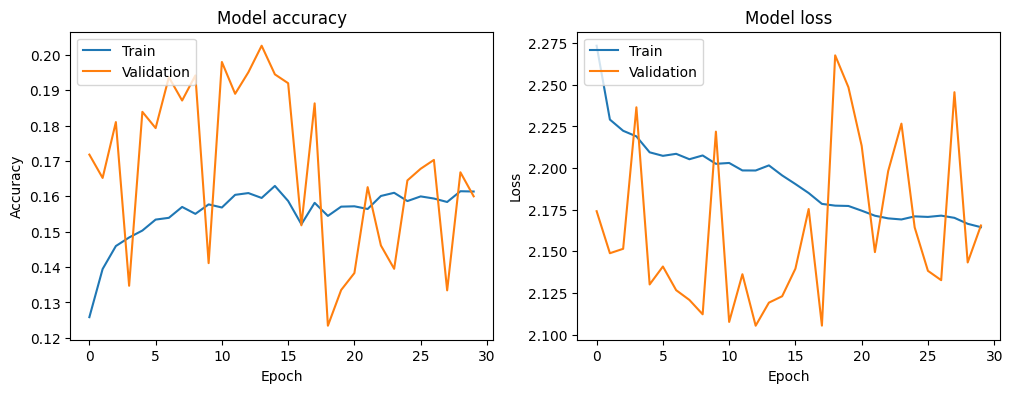

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


##Fine-Tuning --> ResNet50






Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 63ms/step - accuracy: 0.1084 - loss: 2.7349 - val_accuracy: 0.1083 - val_loss: 2.3838 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.1083 - loss: 2.3494 - val_accuracy: 0.1683 - val_loss: 6.9011 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.2096 - loss: 2.0016 - val_accuracy: 0.1996 - val_loss: 2.0150 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.2256 - loss: 1.9788 - val_accuracy: 0.2489 - val_loss: 1.9201 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.2602 - loss: 1.8890 - val_accuracy: 0.1610 - val_loss: 3.8730 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - accuracy: 0.2728 - loss: 1.8605 - val_accuracy: 0.3400 - val_loss: 2.1194 - learning_rate: 0.0010
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - accur

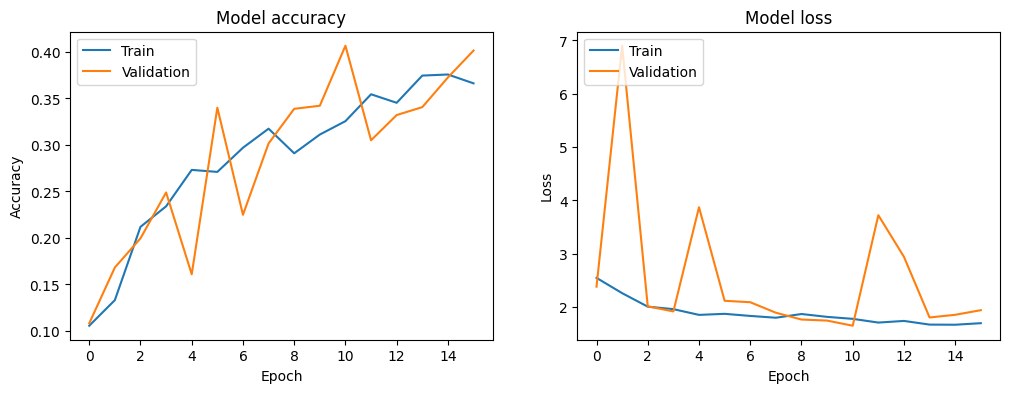

In [ ]:

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unfreeze the top layers of the model
for layer in base_model.layers[-10:]:      # This accesses the last 10 layers of the base_model (ResNet50).
    layer.trainable = True                 # 10 layers trainable, meaning their weights will be updated during backpropagation when training the model.


# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with augmented data
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stop])

# Evaluate model performance on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


##VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.1635 - loss: 2.4898 - val_accuracy: 0.1994 - val_loss: 2.0593 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 39ms/step - accuracy: 0.2128 - loss: 1.9298 - val_accuracy: 0.2074 - val_loss: 2.0899 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.2334 - loss: 1.8684 - val_accuracy: 0.2822 - val_loss: 1.7365 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.2635 - loss: 1.8080 - val_accuracy: 0.1988 - val_loss: 2.4537 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.3005 - loss: 1.7437 - val_accuracy: 0.2876 - val_loss: 2.0779 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.3231 - loss: 1.6796 - val_accuracy: 0.3965 - val_loss: 1.5595 - learning_rate: 0.0010
Epoch 7/50
15

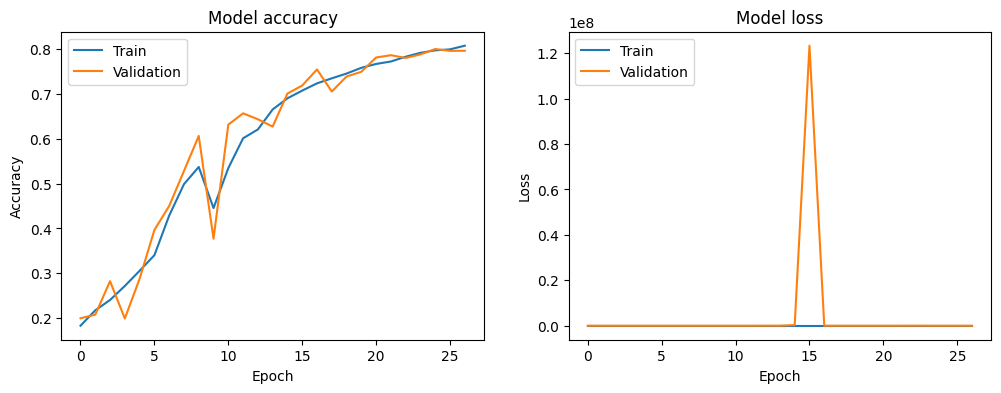

In [ ]:
# VGG16

# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unfreeze the top 4 layers of the model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with augmented data
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stop])

# Evaluate model performance on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


##Save the Model

In [ ]:
model.save('/content/my_model.keras')

# model.save('/content/my_model.h5')


In [ ]:
model = tf.keras.models.load_model('/content/my_model.keras')


##Test the Model

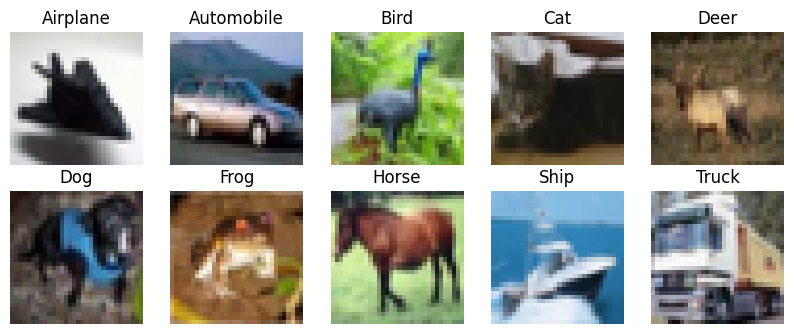

In [ ]:

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Class labels in CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Plot one image from each class
plt.figure(figsize=(10, 10))
for i in range(10):
    # Find the first image of each class
    index = (y_train.argmax(axis=1) == i).nonzero()[0][0]
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[index])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

Lütfən aşağıdakı siniflərdən birinə uyğun şəkil yükləyin:
['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


Saving horse.jpg to horse.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The estimated class of the uploaded photo: Horse


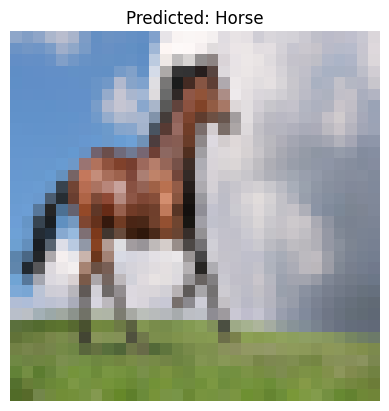

In [ ]:

print("Lütfən aşağıdakı siniflərdən birinə uyğun şəkil yükləyin:")
print(class_names)

uploaded = files.upload()

model = tf.keras.models.load_model('my_model.keras')

def prepare_image(image, target_size):
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image, image_array  # Hem orijinal şəkili, hem də array qaytarır

image_path = next(iter(uploaded))
image = Image.open(image_path)
target_size = (32, 32)


original_image, image_array = prepare_image(image, target_size)


predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=1)

print(f'The estimated class of the uploaded photo: {class_names[predicted_class[0]]}')

plt.imshow(original_image)
plt.title(f'Predicted: {class_names[predicted_class[0]]}')
plt.axis('off')
plt.show()


##Test with my model

In [ ]:
print("Lütfən aşağıdakı siniflərdən birinə uyğun şəkil yükləyin:")
print(class_names)

uploaded = files.upload()

model = tf.keras.models.load_model('/content/Image classification/models/model_VGG16.keras')

def prepare_image(image, target_size):
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image, image_array  # Hem orijinal şəkili, hem də array qaytarır

image_path = next(iter(uploaded))
image = Image.open(image_path)
target_size = (32, 32)


original_image, image_array = prepare_image(image, target_size)


predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=1)

print(f'The estimated class of the uploaded photo: {class_names[predicted_class[0]]}')

plt.imshow(original_image)
plt.title(f'Predicted: {class_names[predicted_class[0]]}')
plt.axis('off')
plt.show()